# Обучение нейросетевого классификатора


In [1]:
!pip install --quiet albumentations pytorch-lightning gdown

## Содержание:
* Ознакомление с Colab
* PyTorch Lightning - исследовательский фрэймворк на PyTorch 
* Albumentations - библиотека для аугментации изображений
* Дополнительная среда разработки 

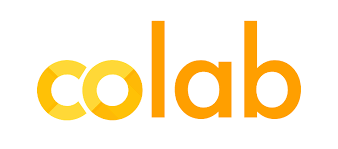

## Что такое Colaboratory?


Colaboratory, или просто Colab, позволяет писать и выполнять код Python в браузере. При этом:
- не требуется никакой настройки;
- вы получаете бесплатный доступ к графическим процессорам;


Для подробного знакомства посмотрите <a href="https://www.youtube.com/watch?v=inN8seMm7UI">ознакомительное видео</a> и/или  <a href="https://colab.research.google.com/notebooks/intro.ipynb#scrollTo=5fCEDCU_qrC0">официальный  intro ноутбук</a>



В Colab Вы получаете 12 бесплатных часов времени выполнения, но ноутбук будет отключен, если вы ничего не будете делать более 60 минут. 
(После 12 часов работы или 1 часа бездействия оперативная память, кэш  и данные, находящиеся на нашей выделенной виртуальной машине, удаляться. Не забывайте сохранять эксперименты.)

### Необходимо сделать сейчас (при открытии ноутбука в colab)
* Включить поддержку GPU: 
<strong>Runtime(Среда выполнения)</strong> -> 
<strong>Change runtime type(Сменить среду выполнения)</strong> -> 
<strong>Hardware accelerator(Аппаратный ускоритель)</strong> -> 
<strong>GPU</strong>


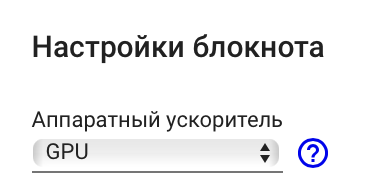

* <strong>Скачать датасет</strong>

In [2]:
!gdown 1b4X24stTroAFkGmBWG4PjS3T-wioVSAn -qcO archive_first_nn.zip

In [3]:
!unzip -qo archive_first_nn.zip -d .

#### Если Вам в будущем будет необходимо загрузить какие-то данные с Google Drive в Colab: ###

In [4]:
# from google.colab import drive
# drive.mount('/content/drive')

------

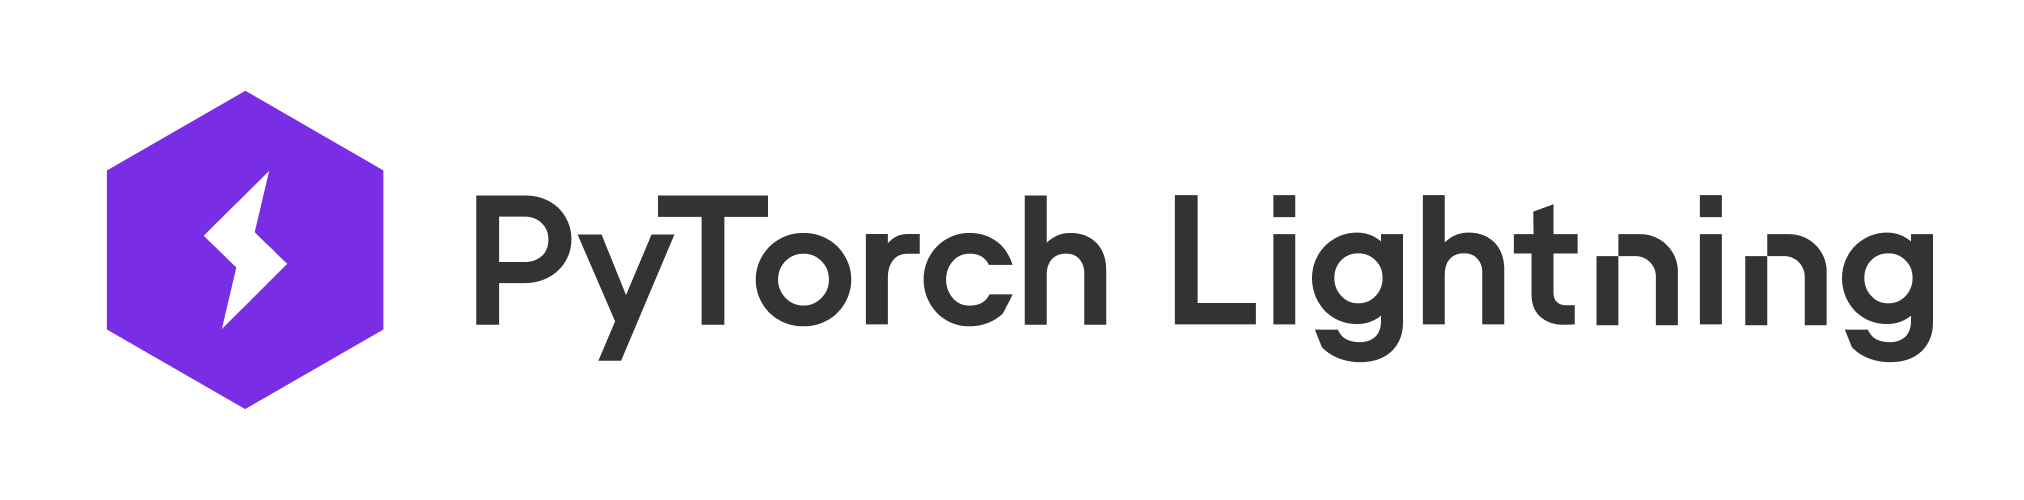

## Почему PyTorch Lightning?


#### 1. Много реализованного функционала
* Обучение на GPU/нескольких GPU/TPU 

* Multi-node training

* Авто логгирование

* Gradient accumulation

* …

#### 2. Меньше инженерного кода
Любое исследование можно начать с простого кода и быстро добавить более сложные (уже реализованные) вещи, такие как: обучение на GPU, 16-bit, сохрание чекпоинтов, логгирование, …

PyTorch Lightning сделал и протестировал много всего за Вас, чтобы Вы могли сосредоточиться на исследовании других идей.

Меньше инженерного кода означает:

* меньше багов

* более быстрое итерирование и прототипирование





#### 3. Не новая библиотека

PyTorch Lightning это всего лишь структурированный PyTorch.

---

<code> "You do the research. Lightning will do everything else."</code>

-----

### Минимальный пример:

In [5]:
## Import required libraries
import pytorch_lightning as pl
import torch
from torch.nn import functional as F
from torch.utils.data import DataLoader
import torchvision 

In [6]:
## Download MNIST Dataset
train_ds = torchvision.datasets.MNIST(".", train=True, download=True, transform=torchvision.transforms.ToTensor())

In [7]:
## Init DataLoader from MNIST Dataset
train_loader = DataLoader(train_ds, batch_size=64, num_workers=6)

In [8]:
class MNISTModel(pl.LightningModule):
    ## REQUIRED METHODS
    def __init__(self):
        super().__init__()
        self.l1 = torch.nn.Linear(28 * 28, 10)
        
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.l1(x)
        x = torch.relu(x)
        return x

    def training_step(self, batch, batch_nb):
        x, y = batch
        loss = F.cross_entropy(self(x), y)
        return loss

    def configure_optimizers(self):
        return torch.optim.SGD(self.parameters(), lr=0.001)
    
    ## OPTIONAL METHOD
    def training_epoch_end(self, outputs):
        ## display average loss across epoch
        avg_loss = torch.stack([x['loss'] for x in outputs]).mean()
        print(f"Epoch {self.trainer.current_epoch}, Train_loss: {round(float(avg_loss), 3)}")

In [9]:
## Init our model
mnist_model = MNISTModel()

## Initialize a trainer
trainer = pl.Trainer(gpus=1, max_epochs=5)

## Train the model ⚡
trainer.fit(mnist_model, train_loader)

/usr/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:447: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: /home/ruro/projects/seminar/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type   | Params
--------------------------------
0 | l1   | Linear | 7.9 K 
--------------------------------
7.9 K     Trainable params
0         Non-trainable params
7.9 K     Total params
0.031     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Epoch 0, Train_loss: 2.043
Epoch 1, Train_loss: 1.54
Epoch 2, Train_loss: 1.218
Epoch 3, Train_loss: 1.031


`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4, Train_loss: 0.911


Как уже было сказано выше в Pytorch Lightning реализовано автологгирование.

Сохранены все запуски: 

In [10]:
!ls lightning_logs/

version_0


In [11]:
!ls lightning_logs/version_0

checkpoints  hparams.yaml


Сохранены веса модели после последней эпохи:

In [12]:
!ls lightning_logs/version_0/checkpoints/

'epoch=4-step=4690.ckpt'


---

### Более сложный пример

Для начала посмотрим на датасет, с которым придеться работать:

In [13]:
import matplotlib.pyplot as plt
import cv2

def show_images(images, titles = []) -> None:
    n: int = len(images)
    f = plt.figure(figsize=(15,15))
    for i in range(n):
        f.add_subplot(1, n, i + 1)
        plt.imshow(images[i])
        if titles != []:
            plt.xlabel(titles[i])

    plt.show(block=True)

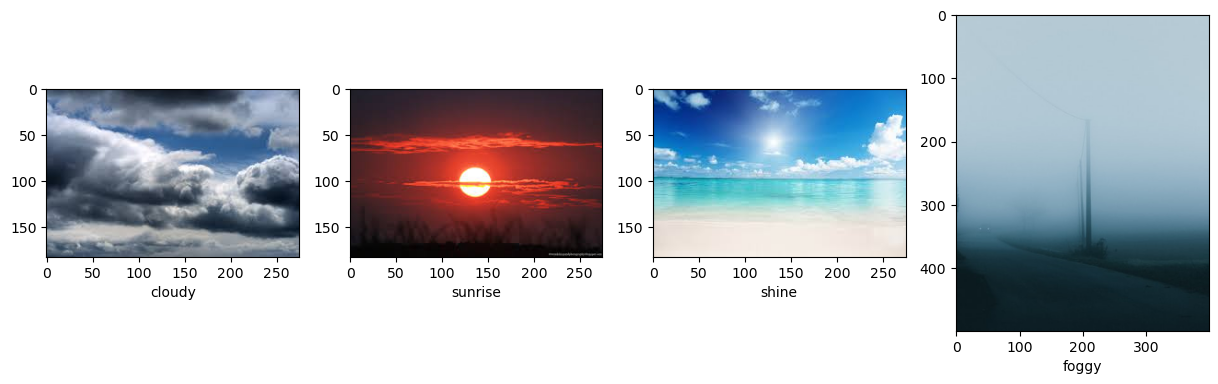

In [14]:
weather_images = []
titles = []
for weather in ['cloudy', 'sunrise', 'shine', 'foggy']:
    weather_images.append(cv2.imread(f"./dataset/{weather}/{weather}103.jpg")[..., ::-1])
    titles.append(weather)
show_images(weather_images, titles)

In [15]:
CLASSES = {"cloudy":0, "foggy":1, "rainy":2, "shine":3, "sunrise":4}

Научимся использовать свои данные при обучении, для этого необхимо создать свой собственный подкласс **`torch.utils.data.Dataset`** (абстракция из PyTorch необходимая для хранения данных).

Также для выбора наилучшей модели понадобится валидационная выборка, которая не должна пересекаться с обучающей.

Ниже представлена реализация трех необходимых функций: **`__init__`**, **`__len__`** - возвращает размер датасета, **`__getitem__`** - возвращает пару объект-метка по индексу


In [16]:
from torch.utils.data import Dataset
from typing import Optional
import os
import numpy as np
from PIL import Image

class MyCustomDataset(Dataset):
    def __init__(self, 
                 mode, 
                 data_dir, 
                 fraction: float = 0.8, 
                 transform = None,
                ):
        
        ## list of tuples: (img_path, label)
        self._items = [] 
        
        ## will use it later for augmentations
        self._transform = transform 

        
        ## we can't store all the images in memory at the same time, 
        ## because sometimes we have to work with very large datasets
        ## so we will only store data paths
        ## (also this is convenient for further augmentations)
        for cl in CLASSES:
            cl_dir = os.listdir(f"./dataset/{cl}")
            if mode == 'train':
                img_pathes = cl_dir[:int(fraction * len(cl_dir))]
            elif mode == 'val':
                img_pathes = cl_dir[int(fraction * len(cl_dir)):]

            for img_path in img_pathes:
                self._items.append((
                    os.path.join(data_dir, cl, img_path),
                    CLASSES[cl]
                ))

    def __len__(self):
        return len(self._items)

    def __getitem__(self, index):

        img_path, label = self._items[index]

        ## read image 
        image = Image.open(img_path).convert('RGB')
        image = np.array(image).astype(np.float32)
        
        ## augmentation
        if self._transform:
            image = self._transform(image=image)['image']

        ## resize
        x = cv2.resize(image, (64,64))

        ## ToTensor
        x = torch.from_numpy(x.transpose(2, 0, 1))

        return x, label

In [17]:
## Init train and val datasets
ds_train = MyCustomDataset(mode = "train", data_dir = "./dataset")
ds_val = MyCustomDataset(mode = "val", data_dir = "./dataset")

## Init train and val dataloaders
dl_train = DataLoader(ds_train, batch_size=32, shuffle=True, num_workers=6)
dl_val = DataLoader(ds_val, batch_size=32, shuffle=False, num_workers=2)

In [18]:
from torch import nn

class MyModel(pl.LightningModule):
    # REQUIRED
    def __init__(self, num_classes):
        super().__init__()
        """ Define computations here. """
        
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.conv3 = nn.Conv2d(16, 5, 3, padding=1)
        self.fc1 = nn.Linear(5 * 7 * 7, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_classes)
        
        ## use cross entropy loss for categorical problems
        self.loss = F.cross_entropy
    
    # REQUIRED
    def forward(self, x):
        """ Use for inference only (separate from training_step). """
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        
        # flatten all dimensions except batch 
        x = torch.flatten(x, 1)     
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
    # REQUIRED
    def training_step(self, batch, batch_idx):
        """the full training loop"""
        x, y = batch

        y_logit = self(x)
        loss = self.loss(y_logit, y)
        
        pred = F.softmax(y_logit, dim=1)
        acc = torch.sum(pred.argmax(dim=1) == y) / y.shape[0]

        return {'loss': loss, 'acc': acc}
    
    # REQUIRED
    def configure_optimizers(self):
        """ Define optimizers and LR schedulers. """
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3, weight_decay=5e-4)
        # optimizer = torch.optim.SGD(self.parameters(), lr=1e-3, momentum=0.9)
        
        lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                                                  mode='max', 
                                                                  factor=0.2, 
                                                                  patience=5, 
                                                                  verbose=True)
        lr_dict = {
            # REQUIRED: The scheduler instance
            "scheduler": lr_scheduler,
            # The unit of the scheduler's step size, could also be 'step'.
            # 'epoch' updates the scheduler on epoch end whereas 'step'
            # updates it after a optimizer update.
            "interval": "epoch",
            # How many epochs/steps should pass between calls to
            # `scheduler.step()`. 1 corresponds to updating the learning
            # rate after every epoch/step.
            "frequency": 1,
            # Metric to to monitor for schedulers like `ReduceLROnPlateau`
            "monitor": "val_acc"
        } 
        
        return [optimizer], [lr_dict]
    
    # OPTIONAL
    def validation_step(self, batch, batch_idx):
        """the full validation loop"""
        x, y = batch

        y_logit = self(x)
        loss = self.loss(y_logit, y)
    
        pred = F.softmax(y_logit, dim=1)
        acc = torch.sum(pred.argmax(dim=1) == y) / y.shape[0]

        return {'val_loss': loss, 'val_acc': acc}

    # OPTIONAL
    def training_epoch_end(self, outputs):
        """log and display average train loss and accuracy across epoch"""
        avg_loss = torch.stack([x['loss'] for x in outputs]).mean()
        avg_acc = torch.stack([x['acc'] for x in outputs]).mean()
        
        print(f"| Train_acc: {avg_acc:.2f}, Train_loss: {avg_loss:.2f}" )
        
        self.log('train_loss', avg_loss, prog_bar=True, on_epoch=True, on_step=False)
        self.log('train_acc', avg_acc, prog_bar=True, on_epoch=True, on_step=False)
     
    # OPTIONAL
    def validation_epoch_end(self, outputs):
        """log and display average val loss and accuracy"""
        avg_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
        avg_acc = torch.stack([x['val_acc'] for x in outputs]).mean()
        
        print(f"[Epoch {self.trainer.current_epoch:3}] Val_acc: {avg_acc:.2f}, Val_loss: {avg_loss:.2f}", end= " ")
        
        self.log('val_loss', avg_loss, prog_bar=True, on_epoch=True, on_step=False)
        self.log('val_acc', avg_acc, prog_bar=True, on_epoch=True, on_step=False)


Мы уже видели, что Pytorch Lightning сохраняет веса модели самостоятельно. Однако сохраняются веса только последней эпохи, метрики на которой могут быть не максимальны, чтобы это исправить самостоятельно напишем callback **`ModelCheckpoint`**.

Также воспользуемся **`EarlyStopping`** для того, чтобы обучение останавливалось при отсутствие роста метрик в течение нескольких эпох.

In [19]:
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks import ModelCheckpoint

## Save the model periodically by monitoring a quantity.
MyModelCheckpoint = ModelCheckpoint(dirpath='runs/pl_classifier',
                                    filename='{epoch}-{val_acc:.3f}',
                                    monitor='val_acc', 
                                    mode='max', 
                                    save_top_k=1)

## Monitor a metric and stop training when it stops improving.
MyEarlyStopping = EarlyStopping(monitor = "val_acc",
                                mode = "max",
                                patience = 4,
                                verbose = True)




In [20]:
trainer = pl.Trainer(
    max_epochs=100,
    gpus=1,
    callbacks=[MyEarlyStopping, MyModelCheckpoint],
    log_every_n_steps=5 # dataset is quite small
)

model = MyModel(num_classes = 5)

trainer.fit(model, dl_train, dl_val)

/usr/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:447: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type      | Params
------------------------------------
0 | conv1 | Conv2d    | 456   
1 | pool  | MaxPool2d | 0     
2 | conv2 | Conv2d    | 880   
3 | conv3 | Conv2d    | 725   
4 | fc1   | Linear    | 29.5 K
5 | fc2   | Linear    | 10.2 K
6 | fc3   | Linear    | 425   
------------------------------------
42.2 K    Trainable params
0         Non-trainable params
42.2 K    Total params
0.169     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/usr/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:236: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


[Epoch   0] Val_acc: 0.64, Val_loss: 1.30 

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_acc improved. New best score: 0.675


[Epoch   0] Val_acc: 0.68, Val_loss: 0.80 | Train_acc: 0.52, Train_loss: 1.12


Validation: 0it [00:00, ?it/s]

Metric val_acc improved by 0.038 >= min_delta = 0.0. New best score: 0.713


[Epoch   1] Val_acc: 0.71, Val_loss: 0.78 | Train_acc: 0.66, Train_loss: 0.85


Validation: 0it [00:00, ?it/s]

[Epoch   2] Val_acc: 0.71, Val_loss: 0.80 | Train_acc: 0.69, Train_loss: 0.79


Validation: 0it [00:00, ?it/s]

[Epoch   3] Val_acc: 0.71, Val_loss: 0.75 | Train_acc: 0.74, Train_loss: 0.69


Validation: 0it [00:00, ?it/s]

[Epoch   4] Val_acc: 0.71, Val_loss: 0.73 | Train_acc: 0.73, Train_loss: 0.66


Validation: 0it [00:00, ?it/s]

Metric val_acc improved by 0.062 >= min_delta = 0.0. New best score: 0.775


[Epoch   5] Val_acc: 0.78, Val_loss: 0.64 | Train_acc: 0.80, Train_loss: 0.56


Validation: 0it [00:00, ?it/s]

[Epoch   6] Val_acc: 0.74, Val_loss: 0.74 | Train_acc: 0.80, Train_loss: 0.51


Validation: 0it [00:00, ?it/s]

Metric val_acc improved by 0.004 >= min_delta = 0.0. New best score: 0.779


[Epoch   7] Val_acc: 0.78, Val_loss: 0.63 | Train_acc: 0.83, Train_loss: 0.44


Validation: 0it [00:00, ?it/s]

[Epoch   8] Val_acc: 0.75, Val_loss: 0.64 | Train_acc: 0.85, Train_loss: 0.42


Validation: 0it [00:00, ?it/s]

Metric val_acc improved by 0.027 >= min_delta = 0.0. New best score: 0.806


[Epoch   9] Val_acc: 0.81, Val_loss: 0.56 | Train_acc: 0.85, Train_loss: 0.40


Validation: 0it [00:00, ?it/s]

[Epoch  10] Val_acc: 0.75, Val_loss: 0.72 | Train_acc: 0.86, Train_loss: 0.38


Validation: 0it [00:00, ?it/s]

[Epoch  11] Val_acc: 0.75, Val_loss: 0.65 | Train_acc: 0.84, Train_loss: 0.42


Validation: 0it [00:00, ?it/s]

[Epoch  12] Val_acc: 0.76, Val_loss: 0.65 | Train_acc: 0.88, Train_loss: 0.33


Validation: 0it [00:00, ?it/s]

Metric val_acc improved by 0.031 >= min_delta = 0.0. New best score: 0.838


[Epoch  13] Val_acc: 0.84, Val_loss: 0.57 | Train_acc: 0.90, Train_loss: 0.26


Validation: 0it [00:00, ?it/s]

[Epoch  14] Val_acc: 0.82, Val_loss: 0.70 | Train_acc: 0.92, Train_loss: 0.22


Validation: 0it [00:00, ?it/s]

[Epoch  15] Val_acc: 0.81, Val_loss: 0.79 | Train_acc: 0.93, Train_loss: 0.20


Validation: 0it [00:00, ?it/s]

[Epoch  16] Val_acc: 0.77, Val_loss: 0.80 | Train_acc: 0.94, Train_loss: 0.16


Validation: 0it [00:00, ?it/s]

Monitored metric val_acc did not improve in the last 4 records. Best score: 0.838. Signaling Trainer to stop.


[Epoch  17] Val_acc: 0.78, Val_loss: 0.92 | Train_acc: 0.93, Train_loss: 0.20


------

#### Tensorboard

Инструментарий визуализации от TensorFlow встроенный создателями Pytorch Lightning

In [21]:
%load_ext tensorboard

In [22]:
%tensorboard --logdir lightning_logs

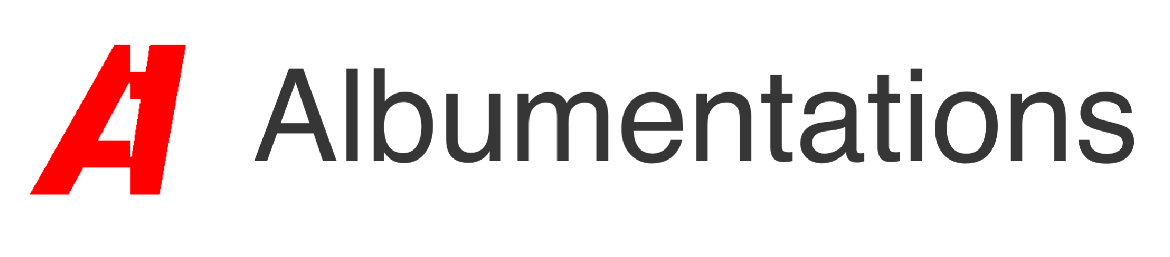

## Почему Albumentations?
Albumentations - это Python библиотека для быстрого и гибкого аугментирования изображений. Albumentations эффективно реализует широкий спектр операций преобразования изображений и обеспечивает при этом лаконичный, но мощный интерфейс для различных задач компьютерного зрения, включая классификацию, сегментацию и детекцию.

### Пример аугментаций из Albumentations:

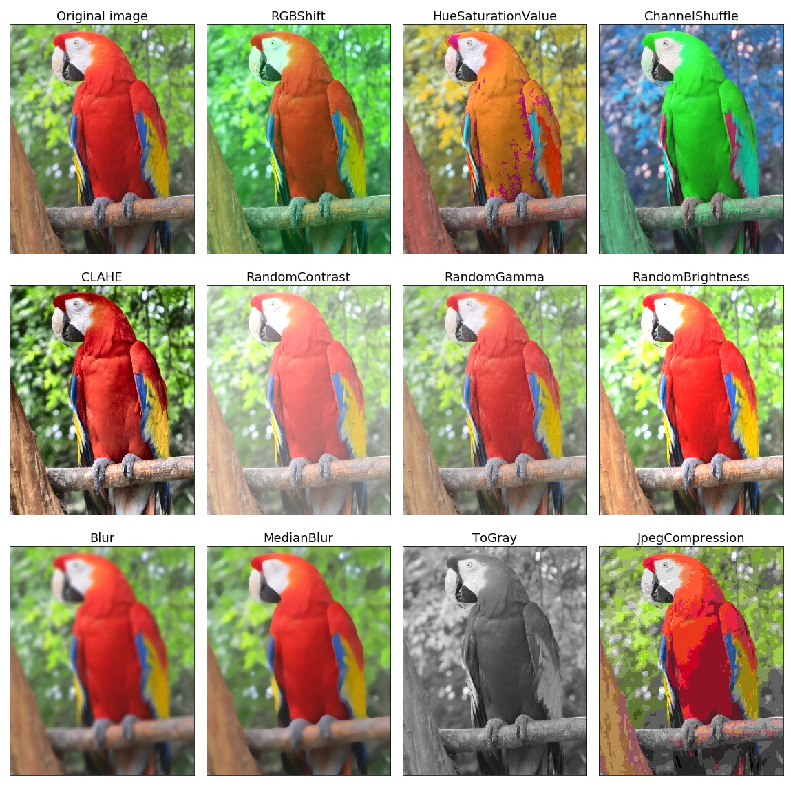

#### Object detection и semantic segmentation на наборе данных Mapillary Vistas:

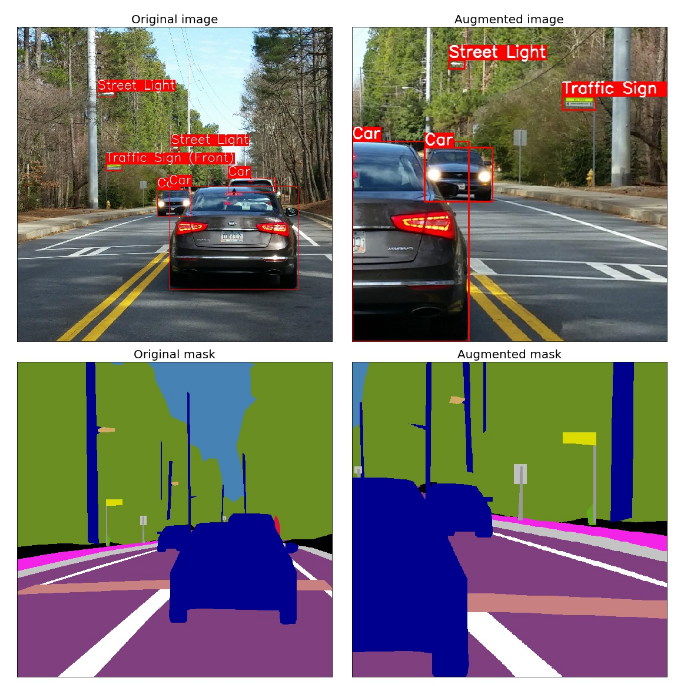

### Пример использования:

In [23]:
import albumentations as A

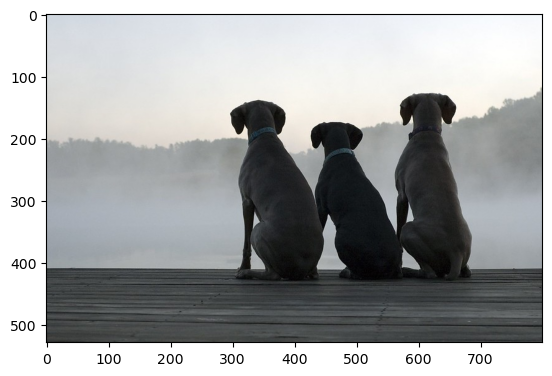

In [24]:
image = cv2.imread("./dataset/alien_test/foggy_9.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)

In [25]:
MyTransform = A.Compose([
    # A.RandomResizedCrop(width=128, height=128, p=0.3),
    A.Rotate(limit=30),
    A.HorizontalFlip(p=0.3),
    A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.5)
])
# MyTransform = A.Compose([
#         A.SmallestMaxSize(max_size=160),
#         A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
#         A.RandomCrop(height=128, width=128),
#         A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
#         A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.5),
#         A.HorizontalFlip(p=0.3),
#         ])

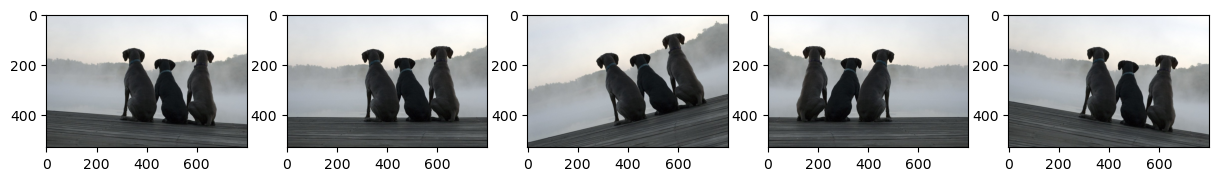

In [26]:
transformed_images = []
for i in range(5):
    transformed_images.append(MyTransform(image=image)['image'])
show_images(transformed_images)

------

### Добавим аугментации в обучение

In [27]:
## Reinit the train dataset using augmentations
ds_train_alb = MyCustomDataset("train", "./dataset", transform=MyTransform)

## Reinit the train dataloader
dl_train_alb = DataLoader(ds_train_alb, batch_size=128, shuffle=True, num_workers=2)

In [28]:
MyEarlyStopping = EarlyStopping(monitor = "val_acc",
                                mode = "max",
                                patience = 10,
                                verbose = True)


MyModelCheckpoint = ModelCheckpoint(dirpath='runs/pl_alb_classifier',
                                      filename='{epoch}-{val_acc:.3f}',
                                      monitor='val_acc', mode='max', save_top_k=1)

In [29]:
trainer = pl.Trainer(
    max_epochs=100,
    gpus=1,
    callbacks=[MyEarlyStopping, MyModelCheckpoint],
    log_every_n_steps=5,
)

model = MyModel(num_classes = 5)

/usr/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:447: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [30]:
trainer.fit(model, dl_train_alb, dl_val)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type      | Params
------------------------------------
0 | conv1 | Conv2d    | 456   
1 | pool  | MaxPool2d | 0     
2 | conv2 | Conv2d    | 880   
3 | conv3 | Conv2d    | 725   
4 | fc1   | Linear    | 29.5 K
5 | fc2   | Linear    | 10.2 K
6 | fc3   | Linear    | 425   
------------------------------------
42.2 K    Trainable params
0         Non-trainable params
42.2 K    Total params
0.169     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/usr/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:236: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


[Epoch   0] Val_acc: 0.00, Val_loss: 2.07 

/usr/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:236: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_acc improved. New best score: 0.219


[Epoch   0] Val_acc: 0.22, Val_loss: 1.57 | Train_acc: 0.20, Train_loss: 1.60


Validation: 0it [00:00, ?it/s]

Metric val_acc improved by 0.094 >= min_delta = 0.0. New best score: 0.312


[Epoch   1] Val_acc: 0.31, Val_loss: 1.42 | Train_acc: 0.25, Train_loss: 1.54


Validation: 0it [00:00, ?it/s]

Metric val_acc improved by 0.230 >= min_delta = 0.0. New best score: 0.543


[Epoch   2] Val_acc: 0.54, Val_loss: 1.30 | Train_acc: 0.32, Train_loss: 1.48


Validation: 0it [00:00, ?it/s]

Metric val_acc improved by 0.042 >= min_delta = 0.0. New best score: 0.584


[Epoch   3] Val_acc: 0.58, Val_loss: 0.97 | Train_acc: 0.36, Train_loss: 1.43


Validation: 0it [00:00, ?it/s]

Metric val_acc improved by 0.054 >= min_delta = 0.0. New best score: 0.639


[Epoch   4] Val_acc: 0.64, Val_loss: 0.93 | Train_acc: 0.45, Train_loss: 1.25


Validation: 0it [00:00, ?it/s]

Metric val_acc improved by 0.008 >= min_delta = 0.0. New best score: 0.647


[Epoch   5] Val_acc: 0.65, Val_loss: 0.85 | Train_acc: 0.42, Train_loss: 1.32


Validation: 0it [00:00, ?it/s]

[Epoch   6] Val_acc: 0.64, Val_loss: 0.91 | Train_acc: 0.44, Train_loss: 1.25


Validation: 0it [00:00, ?it/s]

[Epoch   7] Val_acc: 0.64, Val_loss: 0.87 | Train_acc: 0.44, Train_loss: 1.24


Validation: 0it [00:00, ?it/s]

Metric val_acc improved by 0.034 >= min_delta = 0.0. New best score: 0.681


[Epoch   8] Val_acc: 0.68, Val_loss: 0.82 | Train_acc: 0.47, Train_loss: 1.21


Validation: 0it [00:00, ?it/s]

[Epoch   9] Val_acc: 0.68, Val_loss: 0.77 | Train_acc: 0.49, Train_loss: 1.19


Validation: 0it [00:00, ?it/s]

Metric val_acc improved by 0.078 >= min_delta = 0.0. New best score: 0.759


[Epoch  10] Val_acc: 0.76, Val_loss: 0.69 | Train_acc: 0.49, Train_loss: 1.17


Validation: 0it [00:00, ?it/s]

Metric val_acc improved by 0.028 >= min_delta = 0.0. New best score: 0.788


[Epoch  11] Val_acc: 0.79, Val_loss: 0.64 | Train_acc: 0.51, Train_loss: 1.13


Validation: 0it [00:00, ?it/s]

[Epoch  12] Val_acc: 0.77, Val_loss: 0.71 | Train_acc: 0.50, Train_loss: 1.13


Validation: 0it [00:00, ?it/s]

[Epoch  13] Val_acc: 0.79, Val_loss: 0.62 | Train_acc: 0.54, Train_loss: 1.11


Validation: 0it [00:00, ?it/s]

[Epoch  14] Val_acc: 0.77, Val_loss: 0.64 | Train_acc: 0.53, Train_loss: 1.09


Validation: 0it [00:00, ?it/s]

[Epoch  15] Val_acc: 0.78, Val_loss: 0.68 | Train_acc: 0.55, Train_loss: 1.03


Validation: 0it [00:00, ?it/s]

Metric val_acc improved by 0.009 >= min_delta = 0.0. New best score: 0.797


[Epoch  16] Val_acc: 0.80, Val_loss: 0.62 | Train_acc: 0.50, Train_loss: 1.09


Validation: 0it [00:00, ?it/s]

Metric val_acc improved by 0.003 >= min_delta = 0.0. New best score: 0.800


[Epoch  17] Val_acc: 0.80, Val_loss: 0.59 | Train_acc: 0.51, Train_loss: 1.07


Validation: 0it [00:00, ?it/s]

Metric val_acc improved by 0.019 >= min_delta = 0.0. New best score: 0.819


[Epoch  18] Val_acc: 0.82, Val_loss: 0.58 | Train_acc: 0.53, Train_loss: 1.09


Validation: 0it [00:00, ?it/s]

Metric val_acc improved by 0.022 >= min_delta = 0.0. New best score: 0.841


[Epoch  19] Val_acc: 0.84, Val_loss: 0.53 | Train_acc: 0.55, Train_loss: 1.04


Validation: 0it [00:00, ?it/s]

[Epoch  20] Val_acc: 0.78, Val_loss: 0.65 | Train_acc: 0.52, Train_loss: 1.06


Validation: 0it [00:00, ?it/s]

[Epoch  21] Val_acc: 0.79, Val_loss: 0.60 | Train_acc: 0.51, Train_loss: 1.07


Validation: 0it [00:00, ?it/s]

[Epoch  22] Val_acc: 0.81, Val_loss: 0.58 | Train_acc: 0.57, Train_loss: 1.03


Validation: 0it [00:00, ?it/s]

Metric val_acc improved by 0.016 >= min_delta = 0.0. New best score: 0.856


[Epoch  23] Val_acc: 0.86, Val_loss: 0.51 | Train_acc: 0.54, Train_loss: 1.09


Validation: 0it [00:00, ?it/s]

[Epoch  24] Val_acc: 0.83, Val_loss: 0.55 | Train_acc: 0.58, Train_loss: 0.98


Validation: 0it [00:00, ?it/s]

[Epoch  25] Val_acc: 0.84, Val_loss: 0.55 | Train_acc: 0.57, Train_loss: 0.99


Validation: 0it [00:00, ?it/s]

[Epoch  26] Val_acc: 0.82, Val_loss: 0.59 | Train_acc: 0.54, Train_loss: 1.05


Validation: 0it [00:00, ?it/s]

[Epoch  27] Val_acc: 0.84, Val_loss: 0.51 | Train_acc: 0.56, Train_loss: 1.06


Validation: 0it [00:00, ?it/s]

[Epoch  28] Val_acc: 0.81, Val_loss: 0.61 | Train_acc: 0.57, Train_loss: 1.01


Validation: 0it [00:00, ?it/s]

[Epoch  29] Val_acc: 0.84, Val_loss: 0.54 | Train_acc: 0.55, Train_loss: 1.01
Epoch 00030: reducing learning rate of group 0 to 2.0000e-04.


Validation: 0it [00:00, ?it/s]

[Epoch  30] Val_acc: 0.85, Val_loss: 0.50 | Train_acc: 0.58, Train_loss: 0.98


Validation: 0it [00:00, ?it/s]

[Epoch  31] Val_acc: 0.86, Val_loss: 0.48 | Train_acc: 0.59, Train_loss: 0.95


Validation: 0it [00:00, ?it/s]

[Epoch  32] Val_acc: 0.85, Val_loss: 0.51 | Train_acc: 0.60, Train_loss: 0.95


Validation: 0it [00:00, ?it/s]

Monitored metric val_acc did not improve in the last 10 records. Best score: 0.856. Signaling Trainer to stop.


[Epoch  33] Val_acc: 0.85, Val_loss: 0.50 | Train_acc: 0.60, Train_loss: 0.95


---

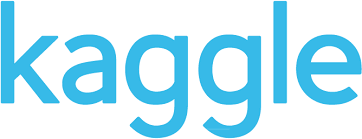

## Обучение на Kaggle  
Если Вам не хватает ресурсов Google Colab'a, можно воспользоваться Kaggle'ом. Обучение здесь похоже на  обучение в Google Colab, хотя в первую очередь сделано для возможности участия в соревнованиях на данной платформе.
Для того, чтобы воспользоваться ресурсами, нужно:
1. Перейти в **"Code"**

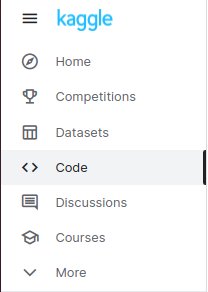

2. Нажать **"New Notebook"**

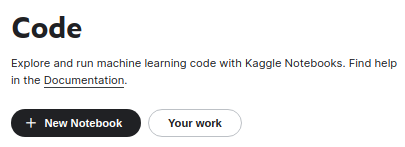

Вы попадаете в схожую среду.
Нажав <strong>"+ Add data"</strong>, Вы можете загрузить свои данные размером до 100GB.

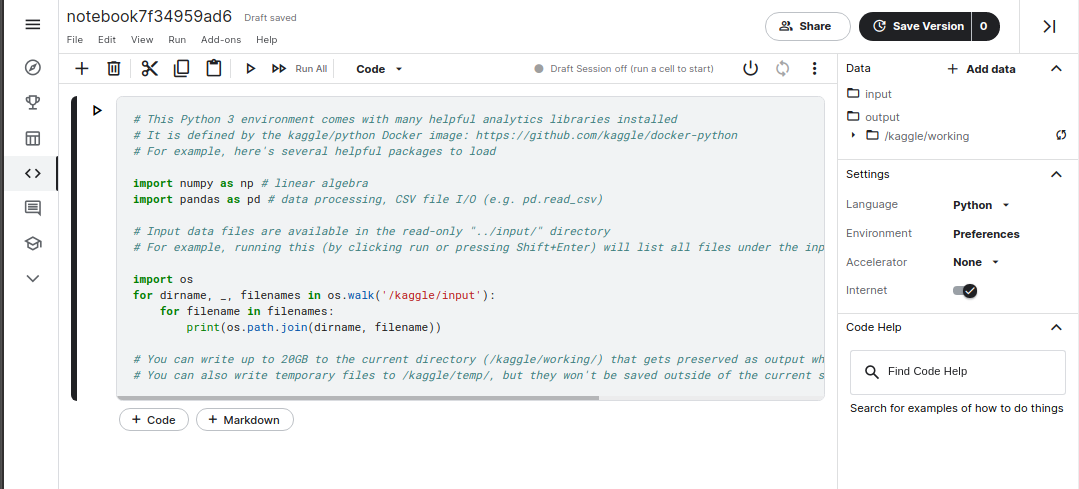

Для более подробного ознакомления можно посмотреть видео с официального канала  Kaggle : <a href="https://www.youtube.com/watch?v=sLAthlX816c">YouTube Tutorial</a> (немного устаревший дизайн, но аналогичный функционал)

Либо прочитать документацию на сайте Kaggle'a:  <a href="www.kaggle.com/docs/notebooks">"How to Use Kaggle?"</a>


---